In [6]:
import sys
sys.path.append("..")
import grading
import download_utils
import tqdm_utils
import tarfile
from PIL import Image
import numpy as np
import os
import cv2
import pandas as pd
import tarfile
import tqdm_utils
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
plt.rcParams.update({'axes.titlesize': 'small'})

from sklearn.datasets import load_digits

RAW_IMAGES_NAME = "faces.tar"  # http://vis-www.cs.umass.edu/lfw/lfw.tgz



In [8]:


def decode_image_from_raw_bytes(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def load_lfw_dataset(
        use_raw=False,
        dx=80, dy=80,
        dimx=45, dimy=45):

    # read photos
    all_photos = []

    with tarfile.open(RAW_IMAGES_NAME) as f:
        for m in tqdm_utils.tqdm_notebook_failsafe(f.getmembers()):
            if m.isfile() and m.name.endswith(".jpg"):
                # prepare image
                
                img = decode_image_from_raw_bytes(f.extractfile(m).read())
                img = cv2.resize(img, (dimx, dimy))
                all_photos.append(img)

    all_photos = np.stack(all_photos).astype('uint8')

    return all_photos

In [9]:

#The following line fetches you two datasets: images, usable for autoencoder training and attributes.
#Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
data = load_lfw_dataset(dimx=52,dimy=52)

#preprocess faces
data = np.float32(data)/255.

IMG_SHAPE = data.shape[1:]

(33431, 52, 52, 3)


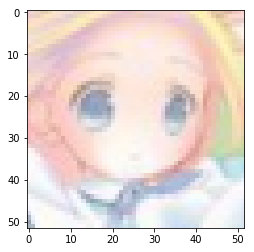

In [10]:
#print random image

print(data.shape)

plt.imshow(data[np.random.randint(data.shape[0])],cmap="gray")

In [11]:
import tensorflow as tf
from keras_utils import reset_tf_session
s = reset_tf_session()

import keras
from keras.models import Sequential
from keras import layers as L

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [13]:
CODE_SIZE = 256

generator = Sequential()
generator.add(L.InputLayer([CODE_SIZE],name='noise'))
generator.add(L.Dense(10*8*8, activation='elu'))

generator.add(L.Reshape((8,8,10)))
generator.add(L.Deconv2D(64,kernel_size=(5,5),activation='elu'))
generator.add(L.Deconv2D(64,kernel_size=(5,5),activation='elu'))
generator.add(L.UpSampling2D(size=(3,3)))
generator.add(L.Deconv2D(32,kernel_size=3,activation='elu'))

generator.add(L.Deconv2D(32,kernel_size=3,activation='elu'))

generator.add(L.Deconv2D(32,kernel_size=3,activation='elu'))

generator.add(L.Conv2D(3,kernel_size=3,activation=None))


In [14]:
assert generator.output_shape[1:] == IMG_SHAPE, "generator must output an image of shape %s, but instead it produces %s"%(IMG_SHAPE,generator.output_shape[1:])

### Discriminator
* Discriminator is your usual convolutional network with interlooping convolution and pooling layers
* The network does not include dropout/batchnorm to avoid learning complications.
* We also regularize the pre-output layer to prevent discriminator from being too certain.

In [15]:
discriminator = Sequential()

discriminator.add(L.InputLayer(IMG_SHAPE))

discriminator.add(L.Conv2D(filters=32,kernel_size=3,padding="same",activation='elu'))    
discriminator.add(L.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None))
discriminator.add(L.Conv2D(filters=64,kernel_size=3,padding="same",activation='elu'))
discriminator.add(L.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None))
discriminator.add(L.Conv2D(filters=128,kernel_size=3,padding="same",activation='elu'))
discriminator.add(L.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None))
discriminator.add(L.Conv2D(filters=256,kernel_size=3,padding="same",activation='elu'))
discriminator.add(L.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None))

discriminator.add(L.Flatten())
discriminator.add(L.Dense(256,activation='tanh'))
discriminator.add(L.Dense(2,activation=tf.nn.log_softmax))

# Training

We train the two networks concurrently:
* Train __discriminator__ to better distinguish real data from __current__ generator
* Train __generator__ to make discriminator think generator is real
* Since discriminator is a differentiable neural network, we train both with gradient descent.

<img src="images/gan.png" width="600px"/>
_© deeplearning4j.org_

Training is done iteratively until discriminator is no longer able to find the difference (or until you run out of patience).


### Tricks:
* Regularize discriminator output weights to prevent explosion
* Train generator with __adam__ to speed up training. Discriminator trains with SGD to avoid problems with momentum.
* More: https://github.com/soumith/ganhacks


In [16]:
noise = tf.placeholder('float32',[None,CODE_SIZE])
real_data = tf.placeholder('float32',[None,]+list(IMG_SHAPE))

logp_real = discriminator(real_data)

generated_data = generator(noise)

logp_gen = discriminator(generated_data)


In [17]:
########################
#discriminator training#
########################

d_loss = -tf.reduce_mean(logp_real[:,1] + logp_gen[:,0])

#regularize
d_loss += tf.reduce_mean(discriminator.layers[-1].kernel**2)

#optimize
disc_optimizer =  tf.train.GradientDescentOptimizer(1e-3).minimize(d_loss,var_list=discriminator.trainable_weights)

In [18]:
########################
###generator training###
########################

g_loss = -tf.reduce_mean(logp_gen[:, 1])

gen_optimizer = tf.train.AdamOptimizer(1e-4).minimize(g_loss,var_list=generator.trainable_weights)

    

In [13]:
#s.run(tf.global_variables_initializer())

### Auxiliary functions
Here we define a few helper functions that draw current data distributions and sample training batches.

In [19]:
def sample_noise_batch(bsize):
    return np.random.normal(size=(bsize, CODE_SIZE)).astype('float32')

def sample_data_batch(bsize):
    idxs = np.random.choice(np.arange(data.shape[0]), size=bsize)
    return data[idxs]

def sample_images(nrow,ncol, sharp=False):
    images = generator.predict(sample_noise_batch(bsize=nrow*ncol))
    if np.var(images)!=0:
        images = images.clip(np.min(data),np.max(data))
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray")
    plt.show()

def sample_probas(bsize):
    plt.title('Generated vs real data')
    plt.hist(np.exp(discriminator.predict(sample_data_batch(bsize)))[:,1],
             label='D(x)', alpha=0.5,range=[0,1])
    plt.hist(np.exp(discriminator.predict(generator.predict(sample_noise_batch(bsize))))[:,1],
             label='D(G(z))',alpha=0.5,range=[0,1])
    plt.legend(loc='best')
    plt.show()

### Training
Main loop.
We just train generator and discriminator in a loop and plot results once every N iterations.

520


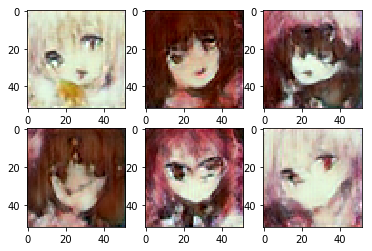

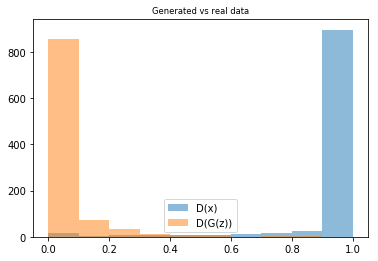

KeyboardInterrupt: 

In [25]:
from IPython import display

for epoch in tqdm_utils.tqdm_notebook_failsafe(range(50000)):
    
    feed_dict = {
        real_data:sample_data_batch(100),
        noise:sample_noise_batch(100)
    }
    
    for i in range(5):
        s.run(disc_optimizer,feed_dict)
    
    s.run(gen_optimizer,feed_dict)
    
    if epoch %20==0:
        display.clear_output(wait=True)
        print(epoch)
        sample_images(2,3,True)
        sample_probas(1000)
        